In [5]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import glob
import copy
import sep

from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.nddata import Cutout2D

from photutils.aperture import SkyCircularAperture
from photutils.aperture import SkyCircularAnnulus
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)

from astropy.io import fits
from astropy.visualization import ZScaleInterval, \
    PercentileInterval, \
    AsymmetricPercentileInterval
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Some useful functions from my code
from kungpao import io
from kungpao.isophote import galSBP
from kungpao import utils
from kungpao import detection
from kungpao import imtools
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

# Convolution kernel I used for detecting objects on the image
kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

# Increase the pixel stack for large image
sep.set_extract_pixstack(10000000)

home = '/home/jpcalderon/'
fitsdir = home + '2023/Fornax/notebooks/Campos/'
output_dir = home + '2023/Fornax/notebooks/Campos/'

In [7]:
# Coordenadas aproximadas del centro del campo
positions = SkyCoord.from_name('NGC 1399')
ra = str(positions.ra.deg)
dec = str(positions.dec.deg)

print (ra, dec)

54.62117917 -35.45074167


In [8]:
filter = 'I'
image = fitsdir + 'NGC1399_' + filter + '.fits'

p = (12393.548, 10470.208)
s = 35 * 2 * u.arcmin
# Load the image and the WCS
hdu = fits.open(image)[0]
wcs = WCS(hdu.header)

# Make the cutout, including the WCS
cutout = Cutout2D(hdu.data, position=p, size=s, wcs=wcs)

# Put the cutout image in the FITS HDU
hdu.data = cutout.data

# Update the FITS header with the cutout WCS
hdu.header.update(cutout.wcs.to_header())

# Write the cutout to a new FITS file
cutout_filename = fitsdir + 'NGC1399_' + filter + '-cutout.fits'
hdu.writeto(cutout_filename, overwrite=True)

In [12]:
image = fitsdir + 'NGC1399_'+filter+'-cutout.fits'

phot_table = pd.DataFrame()

with fits.open(image) as hdul: 
    hdr = hdul[0].header 
    data = hdul[0].data  
    wcs   = WCS ( hdr )

hdr['PixelSc'] = 0.55
hdr['Exptime'] = 1

aperture = SkyCircularAperture ( positions, r = 27.0 * u.arcmin )
anncielo = SkyCircularAnnulus ( positions, 28.0 * u.arcmin, 29.0 * u.arcmin )

apers = [ aperture, anncielo ] 
phot_table = aperture_photometry ( data, apers, wcs = wcs )

bkg_mean = phot_table['aperture_sum_1'] / anncielo.to_pixel(wcs).area 
bkg_sum = bkg_mean * aperture.to_pixel(wcs).area                   
phot_table['flux corrected'] = phot_table['aperture_sum_0'] - bkg_sum 
            
# Agregado para calcular los errores
bg_method = 'mode'
bg_phot = aperture_stats_tbl ( data, anncielo.to_pixel(wcs), sigma_clip = True )
ap_area = aperture.to_pixel(wcs).area
phot_table['flux_error'] = compute_phot_error ( phot_table['flux corrected'], bg_phot, bg_method, ap_area )
# Agregado para calcular los errores
        
phot_table [ filter ] = 25.0 - 2.5 * np.log10( phot_table['aperture_sum_0'] ) 
phot_table [ filter + ' err' ] = 1.0857 * phot_table['flux_error'] / phot_table['flux corrected']
    
phot_table

<QTable length=1>
  id       xcenter      ...        I                I err       
             pix        ...                                     
int64      float64      ...     float64            float64      
----- ----------------- ... ---------------- -------------------
    1 3815.410206775336 ... 7.70277596164636 0.00128781835408326

In [13]:
img_dir = fitsdir

# One of my favorite galaxies of all time
hdr_test = fits.open(os.path.join(img_dir, 'NGC1399_'+filter+'-cutout.fits'))[0].header
img_test = fits.open(os.path.join(img_dir, 'NGC1399_'+filter+'-cutout.fits'))[0].data
wcs_test = WCS(hdr_test)

# For running sep
img_test = img_test.byteswap().newbyteorder()

img_w, img_h = img_test.shape

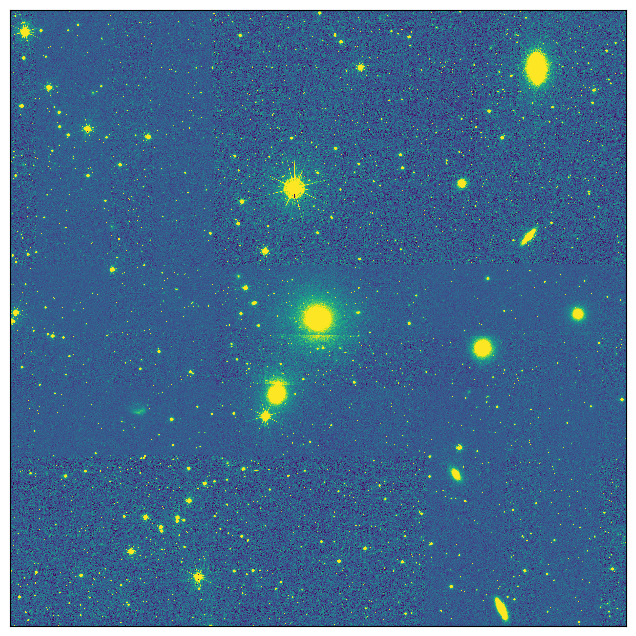

In [14]:
_ = display_single(img_test, contrast=0.2, scale_bar=None)

# Mean Sky / RMS Sky =    0.00322 /    0.11843


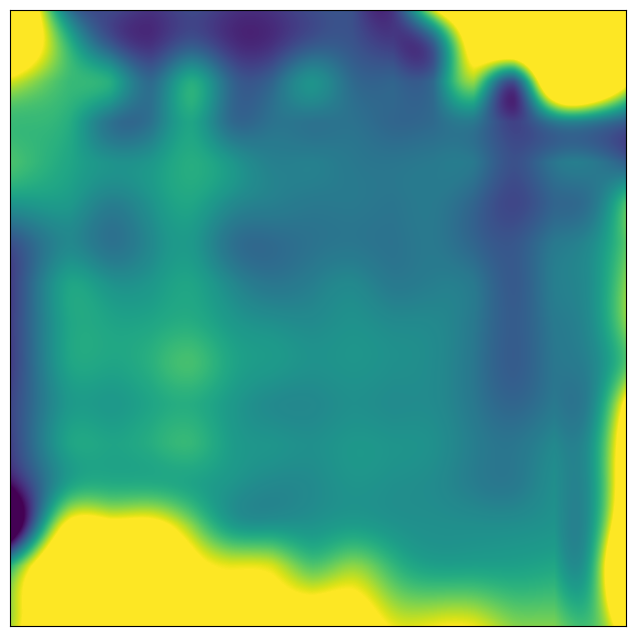

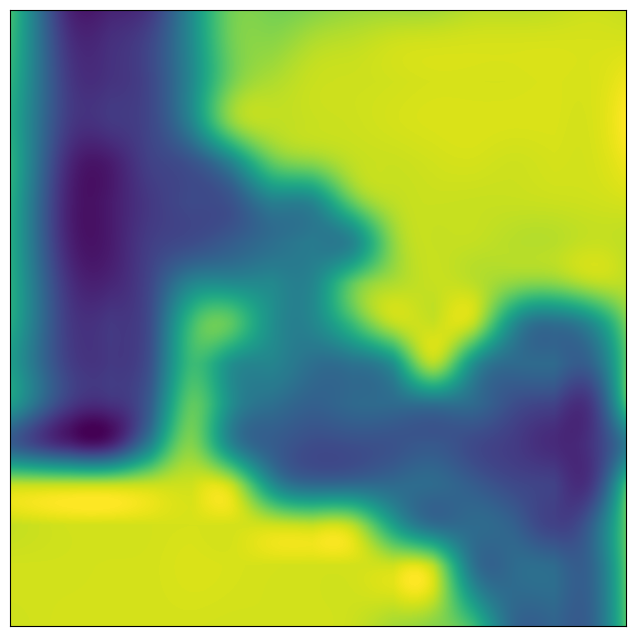

In [15]:
#bkg_local = sep.Background(img_test, bw=200, bh=200, fw=4, fh=4)
bkg_local = sep.Background(img_test,maskthresh=0.0,bw=500,bh=500,fw=50,fh=50,fthresh=0.0)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_local.globalback, bkg_local.globalrms))

_ = display_single(bkg_local.back(), contrast=0.5, scale_bar=None)


# The RMS map will be used as the image error for object detection 
_ = display_single(bkg_local.rms(), contrast=0.5, scale_bar=None)

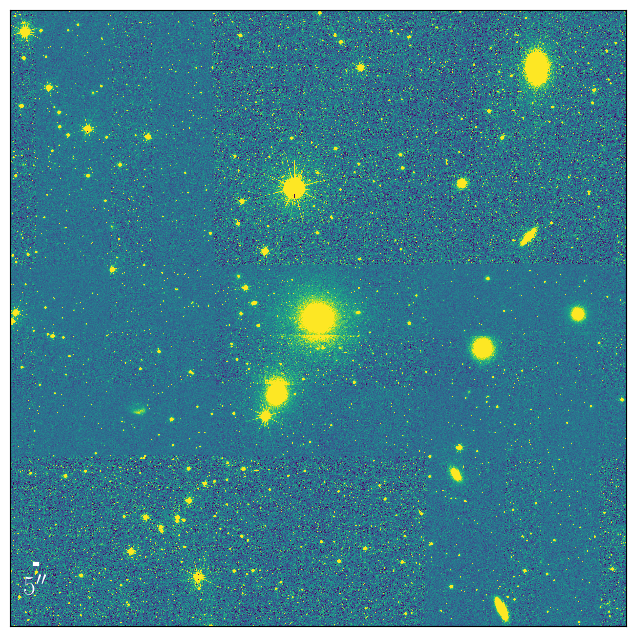

In [16]:
# Subtract the very "local" sky background
img_subbkg = img_test - bkg_local.back()

# As you can see, most of the extended structures have been subtracted off.
_ = display_single(img_subbkg, contrast=0.3)

# Detect 3037 objects


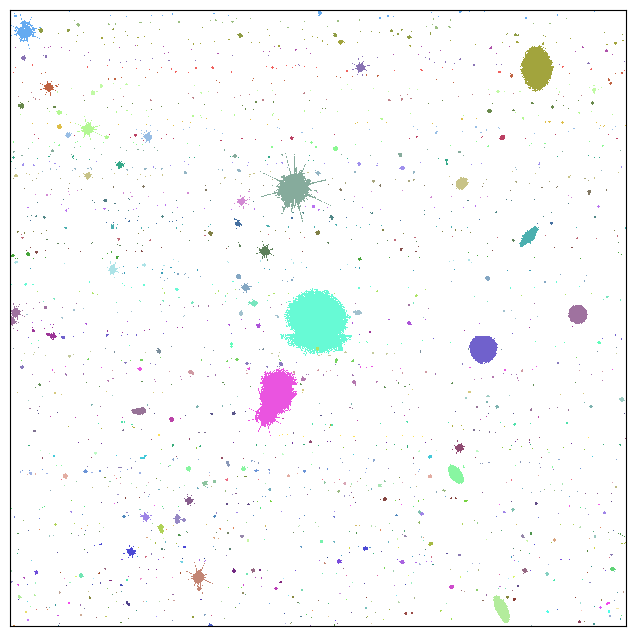

In [17]:
# Do not use very aggressive deblending to avoid breaking the main galaxy into many pieces
# Here we use a high threshold to make sure they represent the bright part of the image.
obj_hthre, seg_hthre = sep.extract(img_subbkg, 7.0,
                                   err=bkg_local.rms(), 
                                   minarea=50, 
                                   filter_kernel=kernel3,
                                   deblend_nthresh=48, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

print("# Detect %d objects" % len(obj_hthre))

_ = display_single(seg_hthre, scale='linear', cmap=SEG_CMAP)

In [19]:
x_cen = 3817.4044 # Tomado del DS9
y_cen = 3778.6897

x2_cen = 3830
y2_cen = 3830

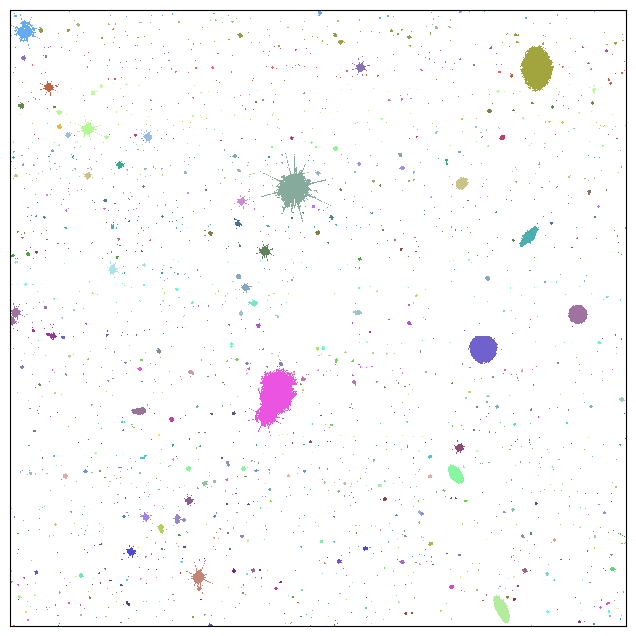

In [20]:
# Now, remove the segmentation associated with the galaxy
# Remember to reverse the order of x and y
seg_nocen1 = imtools.seg_remove_obj(seg_hthre, y_cen, x_cen)
seg_nocen = imtools.seg_remove_obj(seg_nocen1, y2_cen, x2_cen)

_ = display_single(seg_nocen, scale='linear', cmap=SEG_CMAP)

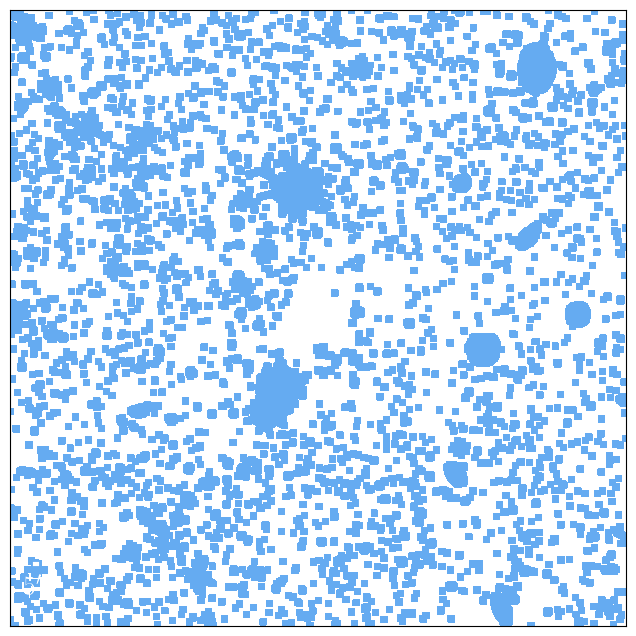

In [21]:
seg_conv = copy.deepcopy(seg_nocen)
seg_conv[seg_nocen > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 5 pixel
# This is actually pretty slow, because the image is very large. 
seg_conv = convolve(seg_conv.astype('float'), Gaussian2DKernel(10.0))

seg_mask = seg_conv >= 1e-11

_ = display_single(seg_mask.astype(int), cmap=SEG_CMAP)

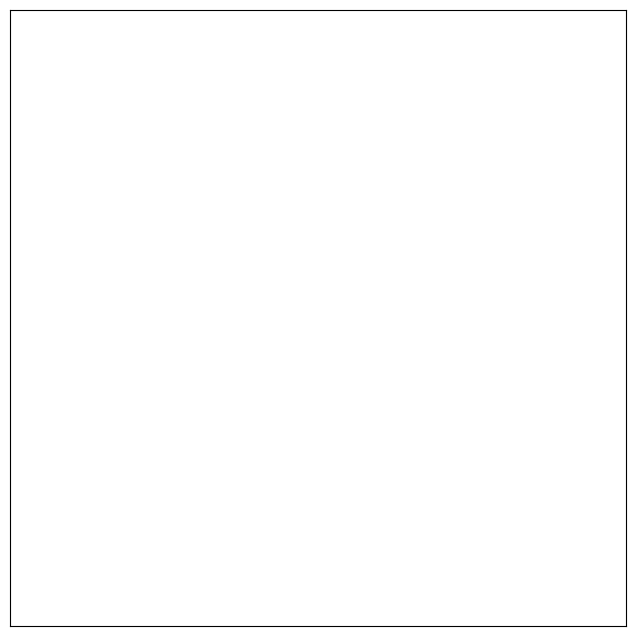

In [22]:
# Low threshold detection to make sure every object is detected
obj_lthre, seg_lthre = sep.extract(img_test - bkg_local.globalback, 3,
                                   err=bkg_local.globalrms, 
                                   minarea=5, 
                                   deblend_nthresh=32, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

_ = display_single(seg_lthre, cmap=SEG_CMAP)

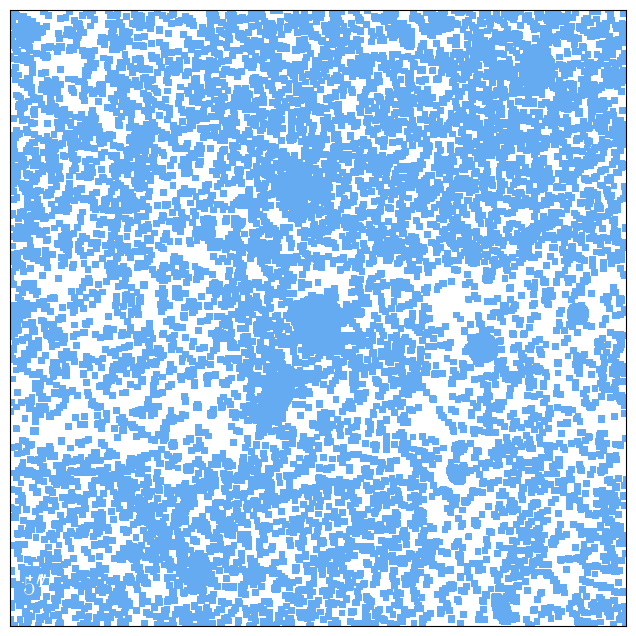

In [23]:
seg_conv = copy.deepcopy(seg_lthre)
seg_conv[seg_lthre > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 10 pixel
bkg_mask = convolve(seg_conv.astype('float'), Gaussian2DKernel(10.0))

bkg_mask = bkg_mask >= 1e-11
_ = display_single(bkg_mask.astype(int), cmap=SEG_CMAP)

# Mean Sky / RMS Sky =   -0.00028 /    0.06628


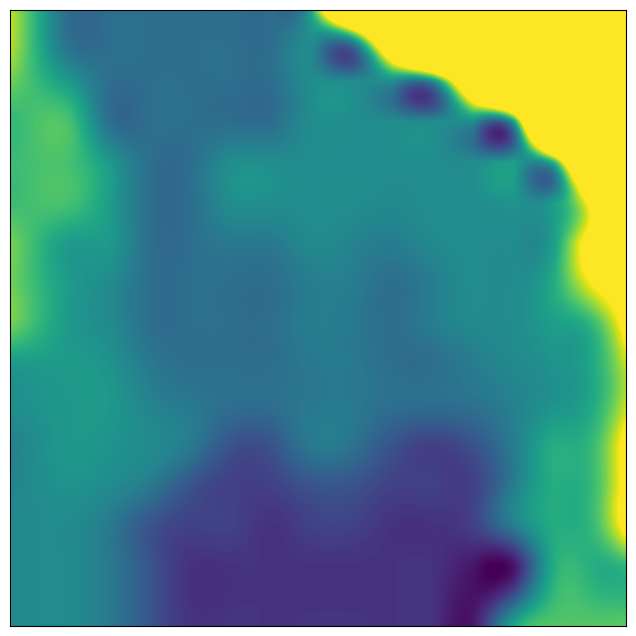

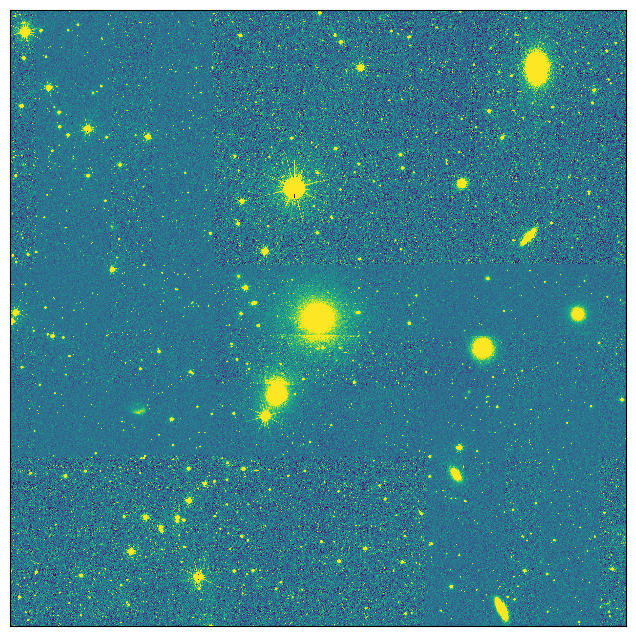

In [24]:
# If you trust your original sky subtraction, this step may not be necessary
# Here it is just for demonstration

bkg_global = sep.Background(img_test, 
                            mask=bkg_mask, maskthresh=0,
                            bw=500, bh=500, 
                            fw=50, fh=50)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_global.globalback, bkg_global.globalrms))

_ = display_single(bkg_global.back(), contrast=0.5, scale_bar=None)

img_corr = img_test - bkg_global.back()

_ = display_single(img_corr, contrast=0.3, scale_bar=None)

In [25]:
img_fits = fitsdir + 'NGC1399_'+filter+'_img.fits'
msk_fits = fitsdir + 'NGC1399_'+filter+'_msk.fits'

_ = io.save_to_fits(img_corr, img_fits)
_ = io.save_to_fits(seg_mask.astype('uint8'), msk_fits)

img_fits_to_phot = fitsdir + 'NGC1399_'+filter+'_to_phot.fits'

img_to_phot = np.multiply(img_corr, ~seg_mask)
_ = io.save_to_fits(img_to_phot, img_fits_to_phot, header = hdr_test)

In [27]:
image = img_fits_to_phot

phot_table = pd.DataFrame()

with fits.open(image) as hdul: 
    hdr = hdul[0].header 
    data = hdul[0].data  
    wcs   = WCS ( hdr )

hdr['PixelSc'] = 0.55
hdr['Exptime'] = 1

aperture = SkyCircularAperture ( positions, r = 27.0 * u.arcmin )
anncielo = SkyCircularAnnulus ( positions, 28.0 * u.arcmin, 29.0 * u.arcmin )

apers = [ aperture, anncielo ] 
phot_table = aperture_photometry ( data, apers, wcs = wcs )

bkg_mean = phot_table['aperture_sum_1'] / anncielo.to_pixel(wcs).area 
bkg_sum = bkg_mean * aperture.to_pixel(wcs).area                   
phot_table['flux corrected'] = phot_table['aperture_sum_0'] - bkg_sum 
            
# Agregado para calcular los errores
bg_method = 'mode'
bg_phot = aperture_stats_tbl ( data, anncielo.to_pixel(wcs), sigma_clip = True )
ap_area = aperture.to_pixel(wcs).area
phot_table['flux_error'] = compute_phot_error ( phot_table['flux corrected'], bg_phot, bg_method, ap_area )
# Agregado para calcular los errores
        
phot_table [ filter ] = 25.0 - 2.5 * np.log10( phot_table['aperture_sum_0'] ) 
phot_table [ filter + ' err' ] = 1.0857 * phot_table['flux_error'] / phot_table['flux corrected']
    
phot_table

<QTable length=1>
  id       xcenter      ...         I                  I err        
             pix        ...                                         
int64      float64      ...      float64              float64       
----- ----------------- ... ------------------ ---------------------
    1 3815.410206775336 ... 10.679365462937739 0.0023607458098135474

# Para el filtro G

In [114]:
image = fitsdir + 'NGC1399_G-cutout.fits'

phot_table = pd.DataFrame()

with fits.open(image) as hdul: 
    hdr = hdul[0].header 
    data = hdul[0].data  
    wcs   = WCS ( hdr )

hdr['PixelSc'] = 0.55
hdr['Exptime'] = 1

aperture = SkyCircularAperture ( positions, r = 33.0 * u.arcmin )
anncielo = SkyCircularAnnulus ( positions, 34.0 * u.arcmin, 35.0 * u.arcmin )

apers = [ aperture, anncielo ] 
phot_table = aperture_photometry ( data, apers, wcs = wcs )

bkg_mean = phot_table['aperture_sum_1'] / anncielo.to_pixel(wcs).area 
bkg_sum = bkg_mean * aperture.to_pixel(wcs).area                   
phot_table['flux corrected'] = phot_table['aperture_sum_0'] - bkg_sum 
            
# Agregado para calcular los errores
bg_method = 'mode'
bg_phot = aperture_stats_tbl ( data, anncielo.to_pixel(wcs), sigma_clip = True )
ap_area = aperture.to_pixel(wcs).area
phot_table['flux_error'] = compute_phot_error ( phot_table['flux corrected'], bg_phot, bg_method, ap_area )
# Agregado para calcular los errores
        
phot_table [ 'g' ] = 25.0 - 2.5 * np.log10( phot_table['aperture_sum_0'] ) 
phot_table [ 'g err' ] = 1.0857 * phot_table['flux_error'] / phot_table['flux corrected']
    
phot_table

<QTable length=1>
  id       xcenter      ...        g               g err        
             pix        ...                                     
int64      float64      ...     float64           float64       
----- ----------------- ... --------------- --------------------
    1 3815.410206775336 ... 8.0810398858474 0.017905440558075747

In [113]:
from astropy.nddata import Cutout2D
image = fitsdir + 'NGC1399_G.fits'
p = (12393.548, 10470.208)
s = 35 * 2 * u.arcmin
# Load the image and the WCS
hdu = fits.open(image)[0]
wcs = WCS(hdu.header)

# Make the cutout, including the WCS
cutout = Cutout2D(hdu.data, position=p, size=s, wcs=wcs)

# Put the cutout image in the FITS HDU
hdu.data = cutout.data

# Update the FITS header with the cutout WCS
hdu.header.update(cutout.wcs.to_header())

# Write the cutout to a new FITS file
cutout_filename = fitsdir + 'NGC1399_G-cutout.fits'
hdu.writeto(cutout_filename, overwrite=True)

In [52]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import math
import glob
import copy
import warnings
import subprocess

import sep
import photutils

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter, MaxNLocator, FormatStrFormatter
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rc('text', usetex=True)

from astropy import wcs
from astropy.io import fits
from astropy.visualization import ZScaleInterval, \
    PercentileInterval, \
    AsymmetricPercentileInterval
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

from astropy.table import Table
from astropy.io import ascii
from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Increase the pixel stack for large image
sep.set_extract_pixstack(10000000)

# Some useful functions from my code

from kungpao import io
from kungpao.isophote import galSBP
from kungpao import utils
from kungpao import detection
from kungpao import imtools
from kungpao.display import display_single, IMG_CMAP, SEG_CMAP

# Convolution kernel I used for detecting objects on the image
kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [115]:
home = '/home/jpcalderon/'
fitsdir = home + '2023/Fornax/notebooks/Campos/'
output_dir = home + '2023/Fornax/notebooks/Campos/'

img_dir = fitsdir

# One of my favorite galaxies of all time
hdr_test = fits.open(os.path.join(img_dir, 'NGC1399_G-cutout.fits'))[0].header
img_test = fits.open(os.path.join(img_dir, 'NGC1399_G-cutout.fits'))[0].data
wcs_test = WCS(hdr_test)

# For running sep
img_test = img_test.byteswap().newbyteorder()

img_w, img_h = img_test.shape

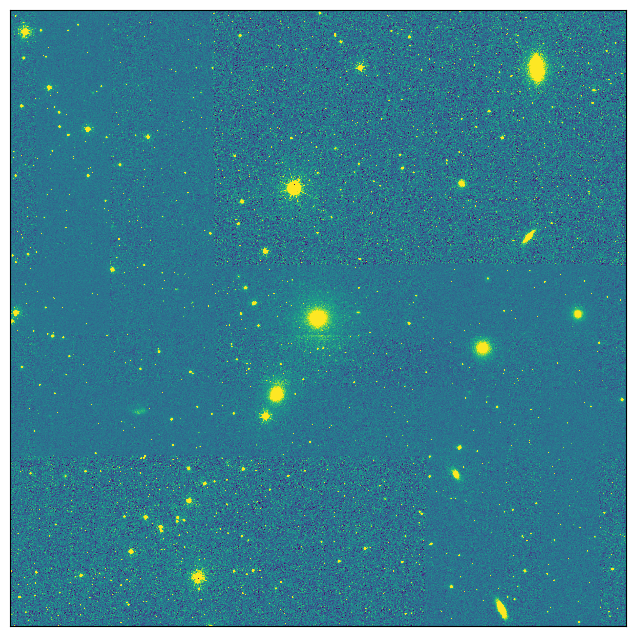

In [116]:
_ = display_single(img_test, contrast=0.2, scale_bar=None)


# Mean Sky / RMS Sky =    0.00611 /    0.10033


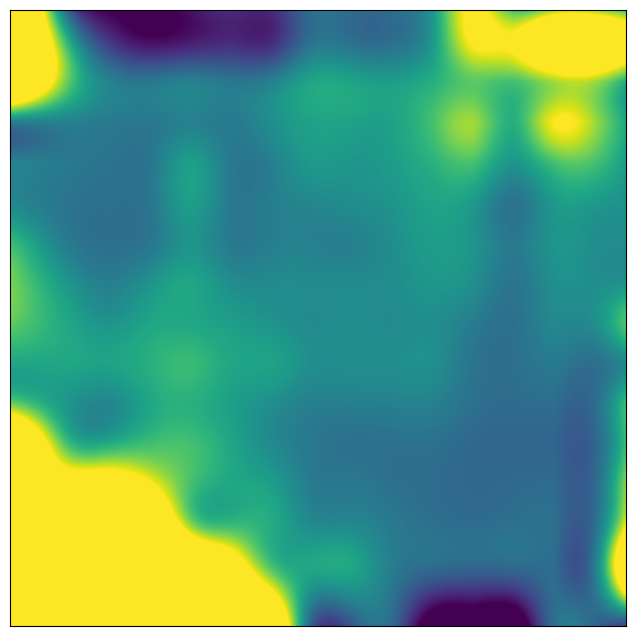

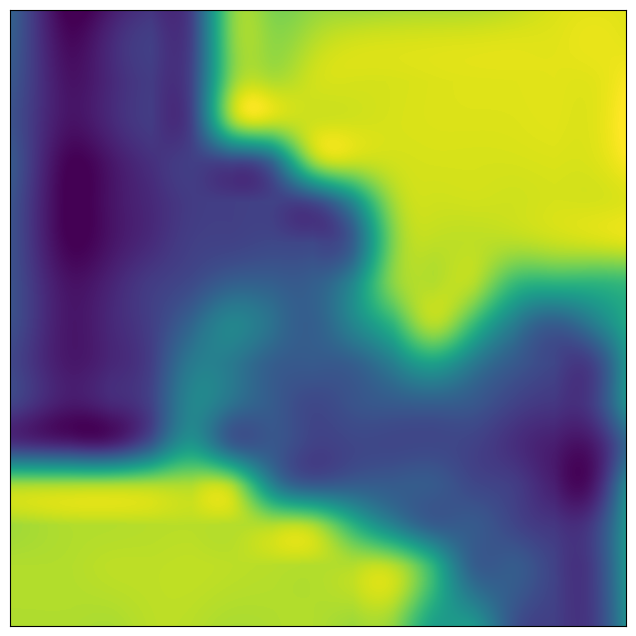

In [118]:
#bkg_local = sep.Background(img_test, bw=200, bh=200, fw=4, fh=4)
bkg_local = sep.Background(img_test,maskthresh=0.0,bw=500,bh=500,fw=50,fh=50,fthresh=0.0)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_local.globalback, bkg_local.globalrms))

_ = display_single(bkg_local.back(), contrast=0.5, scale_bar=None)


# The RMS map will be used as the image error for object detection 
_ = display_single(bkg_local.rms(), contrast=0.5, scale_bar=None)

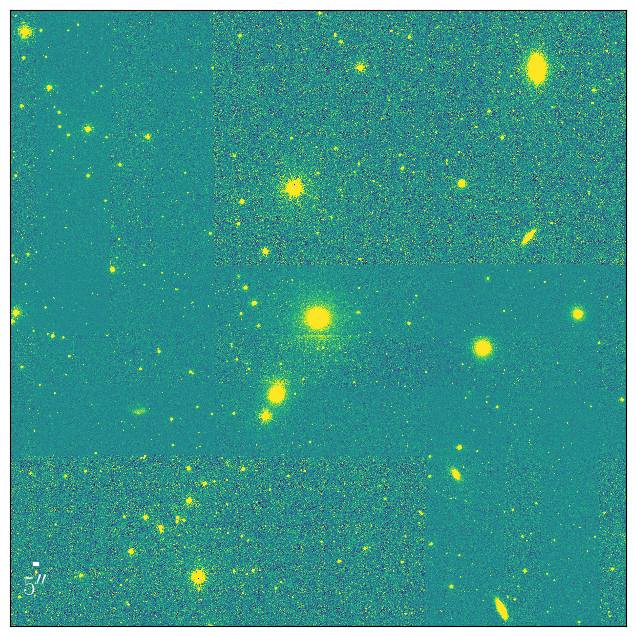

In [119]:
# Subtract the very "local" sky background
img_subbkg = img_test - bkg_local.back()

# As you can see, most of the extended structures have been subtracted off.
_ = display_single(img_subbkg, contrast=0.3)

# Detect 1731 objects


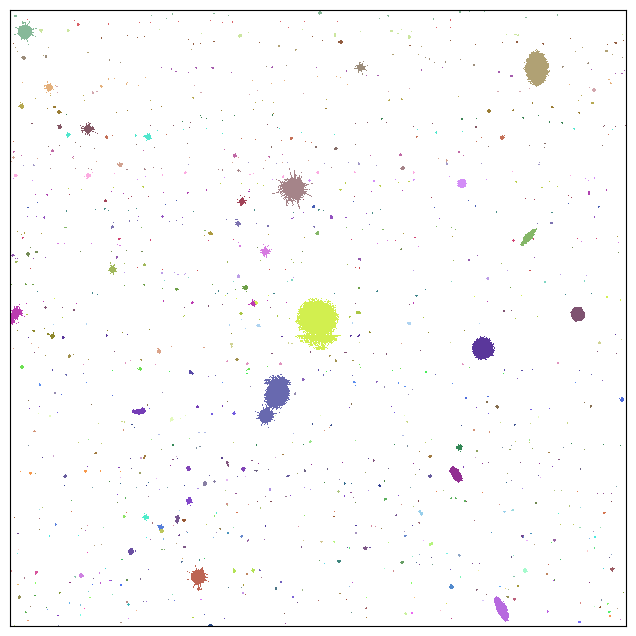

In [120]:
# Do not use very aggressive deblending to avoid breaking the main galaxy into many pieces
# Here we use a high threshold to make sure they represent the bright part of the image.
obj_hthre, seg_hthre = sep.extract(img_subbkg, 7.0,
                                   err=bkg_local.rms(), 
                                   minarea=50, 
                                   filter_kernel=kernel3,
                                   deblend_nthresh=48, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

print("# Detect %d objects" % len(obj_hthre))

_ = display_single(seg_hthre, scale='linear', cmap=SEG_CMAP)

In [121]:
# Or if you know you galaxy is the brightest object on the image, you can do something like this: 

obj_bright = obj_hthre[np.argmax(obj_hthre['flux'])]
print(obj_bright['x'], obj_bright['y'])
x_cen = obj_bright['x']
y_cen = obj_bright['y']

# So, basically find the same galaxy

3523.252440882136 5432.230618019208


In [194]:
x_cen = 3817.4044 # Tomado del DS9
y_cen = 3778.6897

x2_cen = 3830
y2_cen = 3830

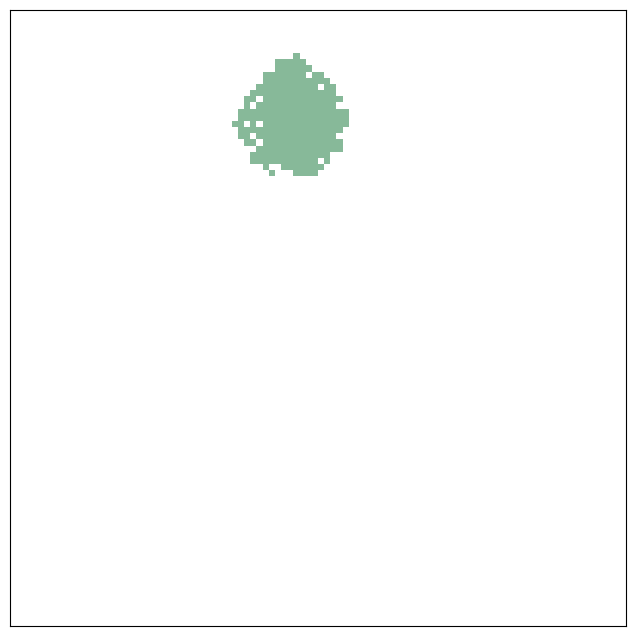

In [197]:
# Now, remove the segmentation associated with the galaxy
# Remember to reverse the order of x and y
seg_nocen1 = imtools.seg_remove_obj(seg_hthre, y_cen, x_cen)
seg_nocen = imtools.seg_remove_obj(seg_nocen1, y2_cen, x2_cen)

a = round(len(seg_nocen)/2)
_ = display_single(seg_nocen[a-50:a+50,a-50:a+50], scale='linear', cmap=SEG_CMAP)

In [188]:
a+25, a+10

(3843, 3828)

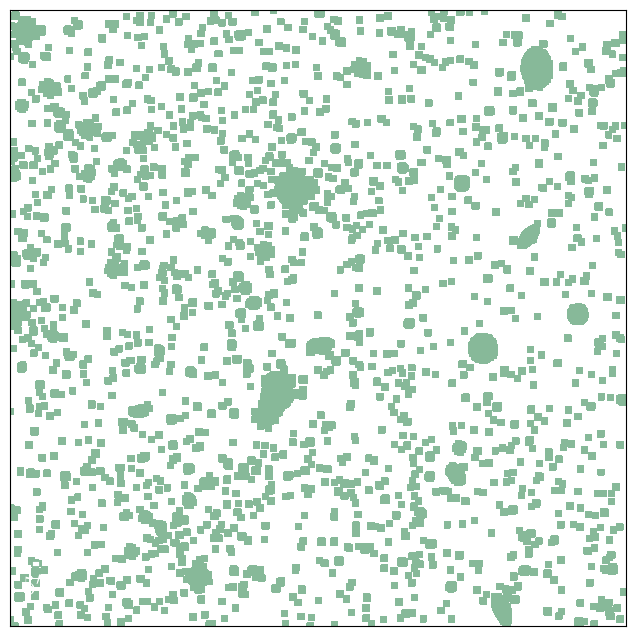

In [209]:
import copy
from astropy.visualization import ZScaleInterval, \
    PercentileInterval, \
    AsymmetricPercentileInterval
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve

seg_conv = copy.deepcopy(seg_nocen)
seg_conv[seg_nocen > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 5 pixel
# This is actually pretty slow, because the image is very large. 
seg_conv = convolve(seg_conv.astype('float'), Gaussian2DKernel(10.0))

seg_mask = seg_conv >= 1e-11

_ = display_single(seg_mask.astype(int), cmap=SEG_CMAP)

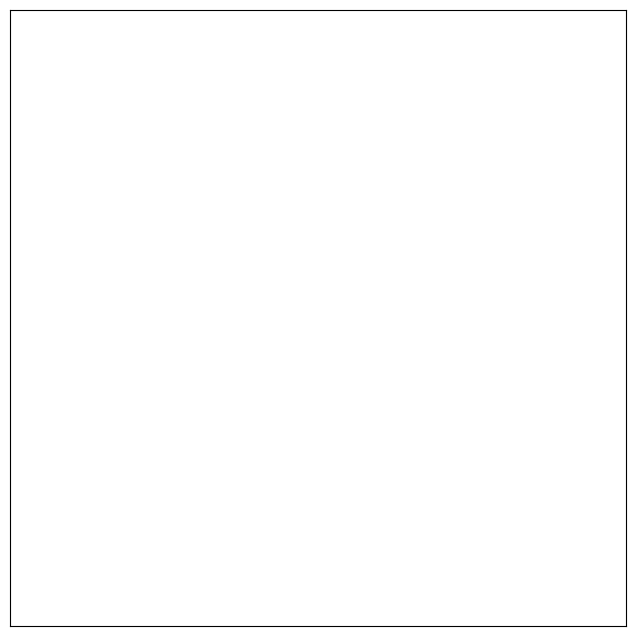

In [224]:
# Low threshold detection to make sure every object is detected
obj_lthre, seg_lthre = sep.extract(img_test - bkg_local.globalback, 3,
                                   err=bkg_local.globalrms, 
                                   minarea=5, 
                                   deblend_nthresh=32, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

_ = display_single(seg_lthre, cmap=SEG_CMAP)

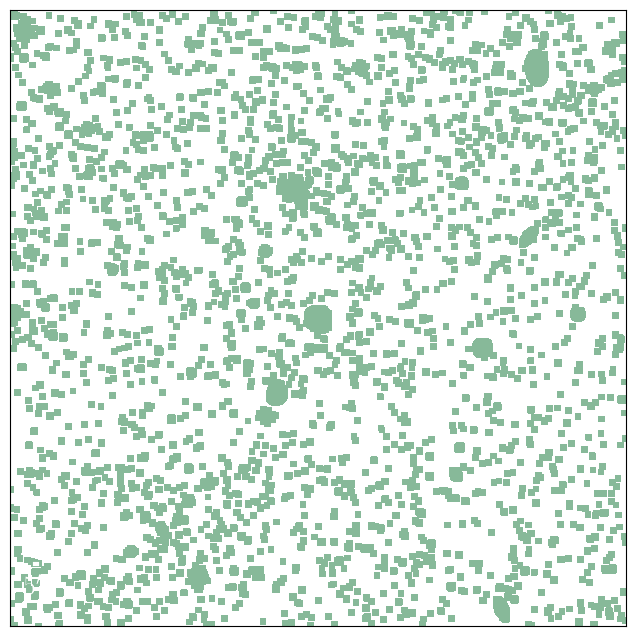

In [221]:
seg_conv = copy.deepcopy(seg_lthre)
seg_conv[seg_lthre > 0] = 1

# Convolve the image with a Gaussian kernel with the width of 10 pixel
bkg_mask = convolve(seg_conv.astype('float'), Gaussian2DKernel(10.0))

bkg_mask = bkg_mask >= 1e-11
_ = display_single(bkg_mask.astype(int), cmap=SEG_CMAP)

# Mean Sky / RMS Sky =    0.00497 /    0.09483


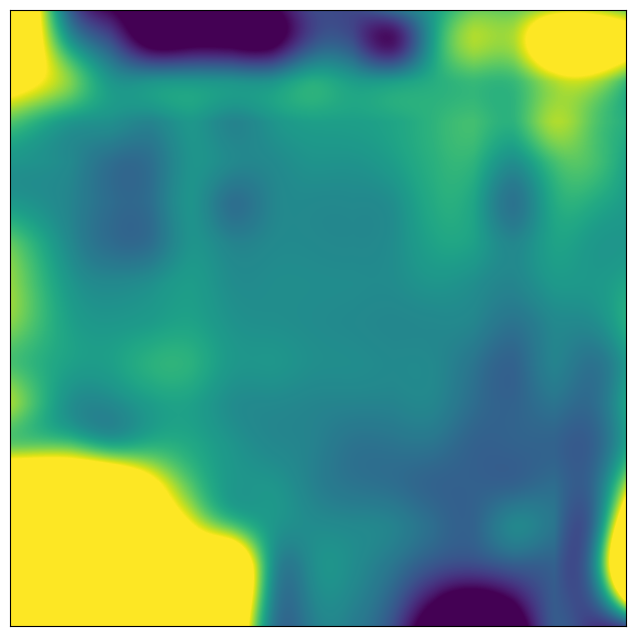

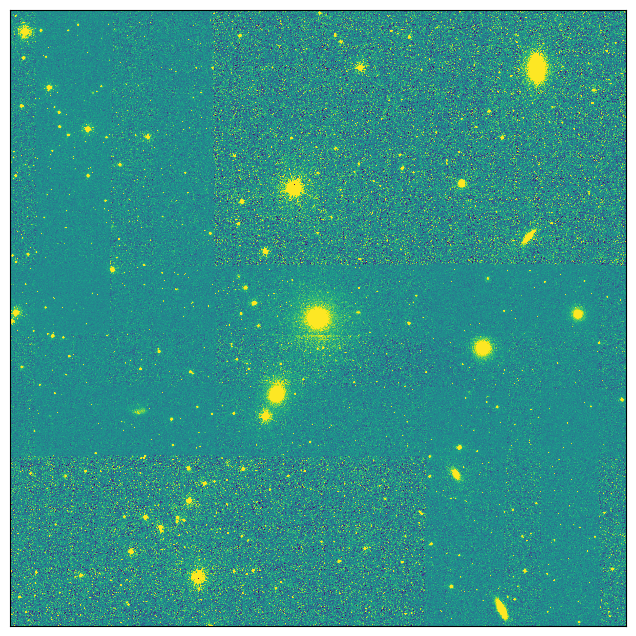

In [225]:
# If you trust your original sky subtraction, this step may not be necessary
# Here it is just for demonstration

bkg_global = sep.Background(img_test, 
                            mask=bkg_mask, maskthresh=0,
                            bw=500, bh=500, 
                            fw=50, fh=50)

print("# Mean Sky / RMS Sky = %10.5f / %10.5f" % (bkg_global.globalback, bkg_global.globalrms))

_ = display_single(bkg_global.back(), contrast=0.5, scale_bar=None)

img_corr = img_test - bkg_global.back()

_ = display_single(img_corr, contrast=0.3, scale_bar=None)

In [226]:
img_fits = fitsdir + 'NGC1399_G_img.fits'
msk_fits = fitsdir + 'NGC1399_G_msk.fits'

_ = io.save_to_fits(img_corr, img_fits)
_ = io.save_to_fits(seg_mask.astype('uint8'), msk_fits)

img_fits_to_phot = fitsdir + 'NGC1399_G_to_phot.fits'

img_to_phot = np.multiply(img_corr, ~seg_mask)
_ = io.save_to_fits(img_to_phot, img_fits_to_phot, header = hdr_test)

In [227]:
img_fits_to_phot = fitsdir + 'NGC1399_G_to_phot.fits'

img_to_phot = np.multiply(img_corr, ~seg_mask)
_ = io.save_to_fits(img_to_phot, img_fits_to_phot, header = hdr_test)

In [228]:
#image = fitsdir + 'NGC1399_G-cutout.fits'
image = img_fits_to_phot

phot_table = pd.DataFrame()

with fits.open(image) as hdul: 
    hdr = hdul[0].header 
    data = hdul[0].data  
    wcs   = WCS ( hdr )

hdr['PixelSc'] = 0.55
hdr['Exptime'] = 1

aperture = SkyCircularAperture ( positions, r = 33.0 * u.arcmin )
anncielo = SkyCircularAnnulus ( positions, 33.0 * u.arcmin, 35 * u.arcmin )

apers = [ aperture, anncielo ] 
phot_table = aperture_photometry ( data, apers, wcs = wcs )

bkg_mean = phot_table['aperture_sum_1'] / anncielo.to_pixel(wcs).area 
bkg_sum = bkg_mean * aperture.to_pixel(wcs).area                   
phot_table['flux corrected'] = phot_table['aperture_sum_0'] - bkg_sum 
            
# Agregado para calcular los errores
bg_method = 'mode'
bg_phot = aperture_stats_tbl ( data, anncielo.to_pixel(wcs), sigma_clip = True )
ap_area = aperture.to_pixel(wcs).area
phot_table['flux_error'] = compute_phot_error ( phot_table['flux corrected'], bg_phot, bg_method, ap_area )
# Agregado para calcular los errores
        
phot_table [ 'g' ] = 25.0 - 2.5 * np.log10( phot_table['aperture_sum_0'] ) 
phot_table [ 'g err' ] = 1.0857 * phot_table['flux_error'] / phot_table['flux corrected']
    
phot_table

<QTable length=1>
  id       xcenter      ...         g                 g err       
             pix        ...                                       
int64      float64      ...      float64             float64      
----- ----------------- ... ------------------ -------------------
    1 3815.410206775336 ... 11.776407209937748 0.01576100613230088

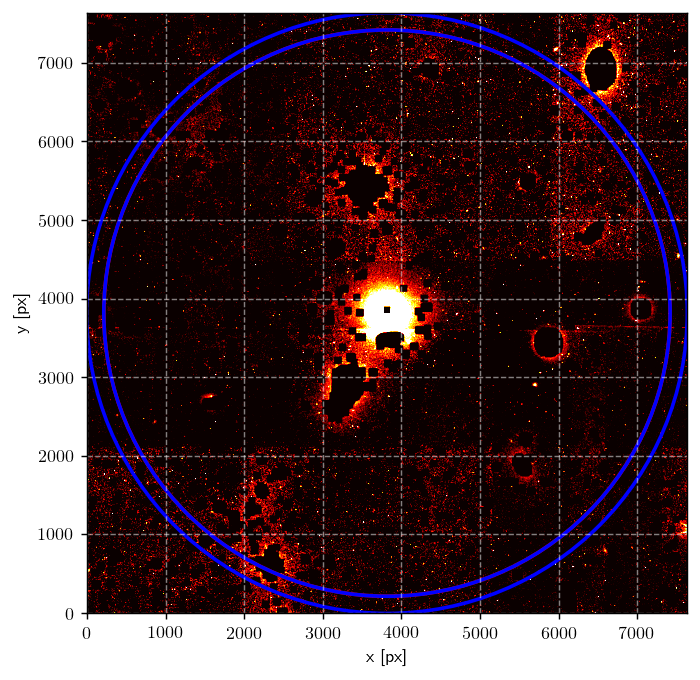

In [220]:
fig, ax = plt.subplots ( ncols = 1, nrows = 1, figsize = (6, 6), dpi = 130 )
ax.imshow ( data, origin = 'lower', vmin = data.mean() - 0*data.std(), 
                 vmax = data.mean() + 1*data.std(), cmap = 'hot' )

ax.set_xlabel ( 'x [px]' )
ax.set_ylabel ( 'y [px]' )

aperture.to_pixel(wcs).plot ( color = 'red', linewidth = 2 )
anncielo.to_pixel(wcs).plot ( color = 'blue', linewidth = 2 )

plt.grid ( color = 'white', linestyle = '--', alpha = 0.5 )

plt.show()

In [111]:
aperture.to_pixel(wcs)

<CircularAperture([1906.41020678, 1905.42428349], r=3600.0000001367384)>

In [115]:
import sep

# Convolution kernel I used for detecting objects on the image
kernel3 = np.asarray([[0.092163, 0.221178, 0.296069, 0.221178, 0.092163],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.296069, 0.710525, 0.951108, 0.710525, 0.296069],
                      [0.221178, 0.530797, 0.710525, 0.530797, 0.221178],
                      [0.092163, 0.221178, 0.296069, 0.221178, 0.092163]])

In [1]:
# Do not use very aggressive deblending to avoid breaking the main galaxy into many pieces
# Here we use a high threshold to make sure they represent the bright part of the image.
obj_hthre, seg_hthre = sep.extract(data.byteswap().newbyteorder(), 7.0,
                                   #err=bkg_local.rms(), 
                                   minarea=50, 
                                   filter_kernel=kernel3,
                                   deblend_nthresh=48, deblend_cont=0.01,
                                   clean=True, clean_param=1.0,
                                   segmentation_map=True)

print("# Detect %d objects" % len(obj_hthre))

NameError: name 'sep' is not defined

In [2]:
# build numpy masked arrays. In these images, pixels with no 
# information in then are signaled by the value zero. We use 
# that to build the masks.
import numpy as np
import numpy.ma as ma

#data_masked = ma.masked_equal(data, np.zeros(shape=data.shape))
data_masked = ma.masked_invalid(data)

In [4]:
from astropy.stats import sigma_clipped_stats
from photutils import make_source_mask

mask = make_source_mask ( data, nsigma = 2, npixels = 2, dilate_size = 2 )
mean, median, std = sigma_clipped_stats ( data, sigma = 3.0, mask = mask )

mask_masked = make_source_mask ( data_masked, nsigma = 2, npixels =2, dilate_size = 2 )
mean_masked, median_masked, std_masked = sigma_clipped_stats ( data_masked, sigma = 3.0, mask = mask_masked )

Estoy tomando un valor fijo para el centro de NGC 1399:

In [32]:
from astropy.wcs.utils import pixel_to_skycoord

pixel_to_skycoord ( 12395.807, 10467.678, wcs, origin = 0 )

<SkyCoord (ICRS): (ra, dec) in deg
    (54.62035457, -35.4507029)>

In [124]:
config = {
      "x0": 12395.807,
      "y0": 12395.807,,
  "minsma": 0,
  "maxsma": 52 / header['PixelSc'],
    "step": ( 52/18 ) / header['PixelSc'], # [arcsec / (arcsec/pixel) ]
    "sma0": 0 +  ( 52/18 ) / header['PixelSc'] * 10, # Con esto empezaria en la mitad
    "eps0": 0.07,
     "pa0": 17
}

In [125]:
from photutils.isophote import EllipseGeometry, Ellipse

g = EllipseGeometry ( x0 = config['x0'], y0 = config['y0'], sma = config['sma0'], 
                            eps = config['eps0'], pa = config['pa0'] )
g.find_center ( data_masked )
ellipse = Ellipse ( data_masked, geometry = g )

INFO: Found center at x0 = 12393.0, y0 = 10470.0 [photutils.isophote.geometry]


In [140]:
#isolist_wide = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.3)
isolist_wide = ellipse.fit_image ( sma0 = config['sma0'], minsma = config['minsma'], maxsma = config['maxsma'], 
                                  step = config['step'], 
                                  conver = 0.05, minit = 10, maxit = 50, fflag = 0.7, maxgerr = 0.5, 
                                  sclip = 3.0, nclip = 0, integrmode = 'median', linear = True, 
                                  maxrit = None, fix_center = False, fix_pa = False, fix_eps = False )
isolist = isolist_wide.to_table().to_pandas()
isophote = isolist_wide

In [141]:
isolist

sma      intens  intens_err  ellipticity  ellipticity_err  \
0    0.000000  160.788867    0.000000     0.000000         0.000000   
1    5.252525   96.089115    1.566297     0.075793         0.001675   
2   10.505051   50.293002    0.494309     0.104501         0.001172   
3   15.757576   30.475873    0.192020     0.118906         0.001233   
4   21.010101   20.371910    0.091196     0.122952         0.001516   
5   26.262626   14.297163    0.042762     0.105480         0.003106   
6   31.515152   13.744056    1.475396     0.067605         0.183557   
7   36.767677    8.664418    0.204921     0.067605         0.028769   
8   42.020202    6.483132    0.020700     0.079000         0.004796   
9   47.272727    5.340576    0.010393     0.098956         0.002336   
10  52.525253    4.281055    0.012212     0.048511         0.002279   
11  57.777778    3.664493    0.010652     0.048511         0.002950   
12  63.030303    3.188968    0.010742     0.048511         0.004029   
13  68.282828    2.803301    0.008182     0.048511         0.004012   
14  73.535354    2.599050    0.003854     0.098438         0.002662   
15  78.787879    2.322899    0.004511     0.081376         0.003264   
16  84.040404    2.082276    0.005543     0.072622         0.004903   
17  89.292929    1.912413    0.003486     0.080470         0.003216   
18  94.545455    1.749133    0.003681     0.074093         0.003643   

            pa     pa_err       grad  grad_err grad_rerr       x0    x0_err  \
0     0.000000   0.000000   0.000000      None      None  12393.0  0.000000   
1    32.594268   0.663580 -12.858899  3.962758  0.308172  12393.0  0.004645   
2    25.760073   0.340124  -5.179477   0.60344  0.116506  12393.0  0.006694   
3    22.610095   0.319804  -2.379900  0.155674  0.065412  12393.0  0.010741   
4    22.713036   0.380096  -1.288226  0.055033   0.04272  12393.0  0.017641   
5    23.464381   0.896329  -0.737603  0.024629  0.033391  12393.0  0.044440   
6   159.035925  80.856598  -0.644135  0.577412  0.896414  12393.0  3.056725   
7   134.152025  12.672739  -0.506985  0.056873   0.11218  12393.0  0.548789   
8    20.278706   1.822405  -0.248094  0.005598  0.022566  12393.0  0.107579   
9    21.364099   0.714650  -0.165133  0.002656  0.016086  12393.0  0.059925   
10   37.249950   1.387896  -0.117791   0.00306  0.025974  12393.0  0.061811   
11   37.249950   1.794981  -0.090761  0.002473   0.02725  12393.0  0.087995   
12   37.249950   2.448958  -0.071541  0.002049  0.028646  12393.0  0.131045   
13   37.249950   2.436931  -0.054468  0.001493  0.027406  12393.0  0.141337   
14   16.313455   0.819528  -0.045595  0.000879  0.019281  12393.0  0.106580   
15   15.041743   1.204642  -0.040070  0.000801  0.019998  12393.0  0.137977   
16   17.823428   2.017157  -0.032351  0.000804  0.024851  12393.0  0.219028   
17   12.510082   1.198021  -0.029260  0.000501  0.017114  12393.0  0.154104   
18   11.868647   1.469316  -0.026626  0.000494  0.018548  12393.0  0.183808   

         y0    y0_err  ndata  flag  niter  stop_code  
0   10470.0  0.000000      1     0      0          0  
1   10470.0  0.004547     32     0     12          0  
2   10470.0  0.006393     63     0     10          0  
3   10470.0  0.010129     94     0     10          0  
4   10470.0  0.016595    125     0     10          0  
5   10470.0  0.042159    157     0     10          0  
6   10470.0  2.949091    192     0     50          2  
7   10470.0  0.549571    224     0     10          0  
8   10470.0  0.103160    255     0     10          0  
9   10470.0  0.056760    283     0     10          0  
10  10470.0  0.061302    324     0     50          2  
11  10470.0  0.087246    356     0     50          2  
12  10470.0  0.129898    388     0     50          2  
13  10470.0  0.140072    420     0     50          2  
14  10470.0  0.100302    441     0     12          0  
15  10470.0  0.131209    477     0     10          0  
16  10470.0  0.210053    511     0     10          0  
17  10470.0  0.146

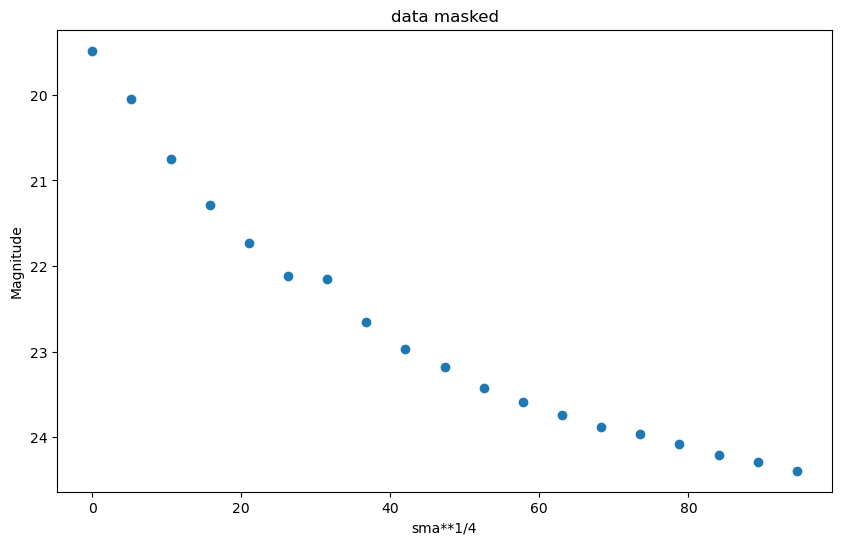

In [142]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(isolist_wide.sma, 25.0-2.5*np.log10(isolist_wide.intens))
plt.title("data masked")
plt.xlabel('sma**1/4')
plt.ylabel('Magnitude')
plt.gca().invert_yaxis()

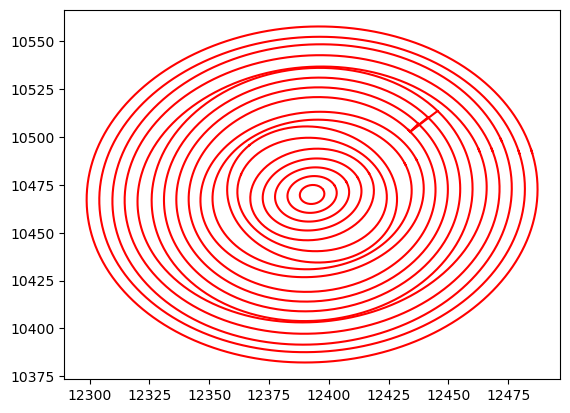

In [143]:
# go to the outermost successfully fitted ellipse at sma=235
isos = []
for sma in isolist['sma']:
    iso = isolist_wide.get_closest(sma)
    isos.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color='red')

In [135]:
isolist

sma      intens  intens_err  ellipticity  ellipticity_err  \
0    0.000000  160.788867    0.000000     0.000000         0.000000   
1    5.252525   96.089115    1.566297     0.075793         0.001675   
2   10.505051   50.293002    0.494309     0.104501         0.001172   
3   15.757576   30.475873    0.192020     0.118906         0.001233   
4   21.010101   20.371910    0.091196     0.122952         0.001516   
5   26.262626   14.297163    0.042762     0.105480         0.003106   
6   31.515152   13.744056    1.475396     0.067605         0.183557   
7   36.767677    8.664418    0.204921     0.067605         0.028769   
8   42.020202    6.483132    0.020700     0.079000         0.004796   
9   47.272727    5.340576    0.010393     0.098956         0.002336   
10  52.525253    4.281055    0.012212     0.048511         0.002279   
11  57.777778    3.664493    0.010652     0.048511         0.002950   
12  63.030303    3.188968    0.010742     0.048511         0.004029   
13  68.282828    2.803301    0.008182     0.048511         0.004012   
14  73.535354    2.599050    0.003854     0.098438         0.002662   
15  78.787879    2.322899    0.004511     0.081376         0.003264   
16  84.040404    2.082276    0.005543     0.072622         0.004903   
17  89.292929    1.912413    0.003486     0.080470         0.003216   
18  94.545455    1.749133    0.003681     0.074093         0.003643   

            pa     pa_err       grad  grad_err grad_rerr       x0    x0_err  \
0     0.000000   0.000000   0.000000      None      None  12393.0  0.000000   
1    32.594268   0.663580 -12.858899  3.962758  0.308172  12393.0  0.004645   
2    25.760073   0.340124  -5.179477   0.60344  0.116506  12393.0  0.006694   
3    22.610095   0.319804  -2.379900  0.155674  0.065412  12393.0  0.010741   
4    22.713036   0.380096  -1.288226  0.055033   0.04272  12393.0  0.017641   
5    23.464381   0.896329  -0.737603  0.024629  0.033391  12393.0  0.044440   
6   159.035925  80.856598  -0.644135  0.577412  0.896414  12393.0  3.056725   
7   134.152025  12.672739  -0.506985  0.056873   0.11218  12393.0  0.548789   
8    20.278706   1.822405  -0.248094  0.005598  0.022566  12393.0  0.107579   
9    21.364099   0.714650  -0.165133  0.002656  0.016086  12393.0  0.059925   
10   37.249950   1.387896  -0.117791   0.00306  0.025974  12393.0  0.061811   
11   37.249950   1.794981  -0.090761  0.002473   0.02725  12393.0  0.087995   
12   37.249950   2.448958  -0.071541  0.002049  0.028646  12393.0  0.131045   
13   37.249950   2.436931  -0.054468  0.001493  0.027406  12393.0  0.141337   
14   16.313455   0.819528  -0.045595  0.000879  0.019281  12393.0  0.106580   
15   15.041743   1.204642  -0.040070  0.000801  0.019998  12393.0  0.137977   
16   17.823428   2.017157  -0.032351  0.000804  0.024851  12393.0  0.219028   
17   12.510082   1.198021  -0.029260  0.000501  0.017114  12393.0  0.154104   
18   11.868647   1.469316  -0.026626  0.000494  0.018548  12393.0  0.183808   

         y0    y0_err  ndata  flag  niter  stop_code  
0   10470.0  0.000000      1     0      0          0  
1   10470.0  0.004547     32     0     12          0  
2   10470.0  0.006393     63     0     10          0  
3   10470.0  0.010129     94     0     10          0  
4   10470.0  0.016595    125     0     10          0  
5   10470.0  0.042159    157     0     10          0  
6   10470.0  2.949091    192     0     50          2  
7   10470.0  0.549571    224     0     10          0  
8   10470.0  0.103160    255     0     10          0  
9   10470.0  0.056760    283     0     10          0  
10  10470.0  0.061302    324     0     50          2  
11  10470.0  0.087246    356     0     50          2  
12  10470.0  0.129898    388     0     50          2  
13  10470.0  0.140072    420     0     50          2  
14  10470.0  0.100302    441     0     12          0  
15  10470.0  0.131209    477     0     10          0  
16  10470.0  0.210053    511     0     10          0  
17  10470.0  0.146

In [50]:
step

5.252525252525252

In [10]:
"""Computes MMM statistics within photutils apertures.
The functions in this script enable the computation of statistics
within a PhotUtils aperture, which is currently not directly
implemented in PhotUtils itself.  This code is meant to be
imported into other code, and then be usable as a single line to
return all the statistics in a format similar to the
aperture_photometry method in PhotUtils (i.e. an astropy table).
Authors
-------
    - Varun Bajaj, December 2017
Use
---
    from background_median import aperture_stats_tbl
    stats_tbl = aperture_stats_tbl(data, apertures)
    See the docstring of aperture_stats_tbl for more info.
"""
import numpy as np

# WAY faster than astropy.stats.sigma_clipped_stats
from scipy.stats import sigmaclip
from astropy.table import Table
from photutils.aperture.mask import ApertureMask

def aperture_stats_tbl(data, apertures,
                       method='exact', sigma_clip=True):
    """Computes mean/median/mode/std in Photutils apertures.
    Compute statistics for custom local background methods.
    This is primarily intended for estimating backgrounds
    via annulus apertures.  The intent is that this falls easily
    into other code to provide background measurements.
    Parameters
    ----------
    data : array
        The data for the image to be measured.
    apertures : photutils PixelAperture object (or subclass)
        The phoutils aperture object to measure the stats in.
        i.e. the object returned via CirularAperture,
        CircularAnnulus, or RectangularAperture etc.
    method: str
        The method by which to handle the pixel overlap.
        Defaults to computing the exact area.
        NOTE: Currently, this will actually fully include a
        pixel where the aperture has ANY overlap, as a median
        is also being performed.  If the method is set to 'center'
        the pixels will only be included if the pixel's center
        falls within the aperture.
    sigma_clip: bool
        Flag to activate sigma clipping of background pixels
    Returns
    -------
    stats_tbl : astropy.table.Table
        An astropy Table with the colums X, Y, aperture_mean,
        aperture_median, aperture_mode, aperture_std, aperture_area
        and a row for each of the positions of the apertures.
    """

    # Get the masks that will be used to identify our desired pixels.
    masks = apertures.to_mask(method=method)
    if isinstance(masks, ApertureMask): # fix different return types
        masks = [masks]

    # Compute the stats of pixels within the masks
    aperture_stats = [calc_aperture_mmm(data, mask, sigma_clip)
                      for mask in masks]

    aperture_stats = np.array(aperture_stats[0])

    # Place the array of the x y positions alongside the stats
    stacked = np.hstack([apertures.positions, aperture_stats])
    # Name the columns
    names = ['X','Y','aperture_mean','aperture_median','aperture_mode',
            'aperture_std', 'aperture_area']
    # Make the table
    stats_tbl = Table(data=stacked, names=names)
    return stats_tbl

def calc_aperture_mmm(data, mask, sigma_clip):
    """Helper function to actually calculate the stats for pixels
        falling within some Photutils aperture mask on some array
        of data.
    """
    cutout = mask.cutout(data, fill_value=np.nan)
    if cutout is None:
        return (np.nan, np.nan, np.nan, np.nan, np.nan)
    else:
        values = cutout * mask.data / mask.data
        values = values[~np.isnan(values)]
        if sigma_clip:
            values, clow, chigh = sigmaclip(values, low=3, high=3)

        mean = np.mean(values)
        median = np.median(values)
        std = np.std(values)

        mode = 3 * median - 2 * mean
        actual_area = (~np.isnan(values)).sum()
        return (mean, median, mode, std, actual_area)

def compute_phot_error(
        flux_variance,
        bg_phot,
        bg_method,
        ap_area,
        epadu=1.0):
    """Computes the flux errors using the DAOPHOT style computation"""
    bg_variance_terms = (ap_area * bg_phot['aperture_std'] ** 2. ) \
                        * (1. + ap_area/bg_phot['aperture_area'])
    variance = flux_variance / epadu + bg_variance_terms
    flux_error = variance ** .5
    return flux_error